<a href="https://colab.research.google.com/github/Eliandry/Neural-networks/blob/main/guessEmotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import os
from keras.models import Sequential
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D,BatchNormalization
from google.colab import files
from PIL import Image
from keras.applications import vgg19
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


(48, 48, 1)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


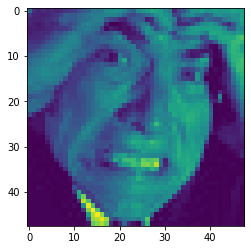

In [103]:
x_train=[]
y_train=[]
for i in range(26):
  img = Image.open(f'/content/tAngry/1 ({i+1}).jpg')
  img=np.array(img)
  x_img=vgg19.preprocess_input(np.expand_dims(img,axis=0))
  x_img.shape=(48,48,1)
  x_train.append(x_img)
  y_train.append(0)

for i in range(35):
  img = Image.open(f'/content/tHappy/2 ({i+1}).jpg')
  img=np.array(img)
  x_img=vgg19.preprocess_input(np.expand_dims(img,axis=0))
  x_img.shape=(48,48,1)
  x_train.append(x_img)
  y_train.append(1)

print(x_train[0].shape)
print(y_train)


In [104]:
#y_train=to_categorical(y_train,4)
x_train=np.expand_dims(x_train,axis=3)
x_train=x_train.reshape(x_train.shape[0], 48, 48, 1)
x=x_train/255
y_train=to_categorical(y_train,2)

In [120]:
num_features = 32
num_labels = 2
batch_size = 16
epochs = 100
width, height = 48, 48

In [135]:
model = Sequential()
if 1==1:
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

In [136]:
model.compile(loss="binary_crossentropy",
                  optimizer='Adam',
                  metrics=['accuracy'])

In [137]:
print(y_train[1])
model.fit(np.array(x), np.array(y_train),
              batch_size=batch_size,
              epochs=100,
              verbose=1)

[1. 0.]
Epoch 1/20


ValueError: ignored

array([[0., 1.]], dtype=float32)

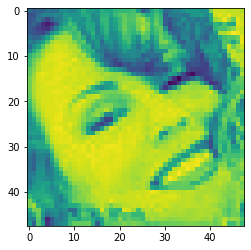

In [125]:
imgs = Image.open(f'/content/tHappy/2 (34).jpg')
plt.imshow(imgs)
x_img=vgg19.preprocess_input(np.expand_dims(imgs,axis=0))
x_img.shape=(x_img.shape[0],48,48,1)
model.predict(x_img)
